# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 47 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
# from scipy.misc.pilutil import imread, imresize
import cv2 as cv

In [5]:
def updateImage(image, y, z):
    h, w, c = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return cv.resize(image, (y,z))



In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
    x = len(img_idx)
    y,z = 100,100
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = updateImage(image,y,z)

                    batch_data[folder,idx,:,:,0] = image[:, : , 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]/255#normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = updateImage(image,100,100)

                    batch_data[folder,idx,:,:,0] = image[:, : , 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]/255#normalise and feed in the image
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = Sequential()


model.add(Conv3D(16,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu',input_shape=(10, 100, 100, 3)))
model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(64,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128, activation='elu'))
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 16)  1312      
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 100, 100, 32)  13856     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 33, 33, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 33, 33, 32)    128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 33, 33, 32)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 33, 33, 64)     5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-13-bd77c9c60c14>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 47
Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.0414 - categorical_accuracy: 0.2071 Source path =  Project_data/val ; batch size = 47

Epoch 1: saving model to model_init_2022-08-2307_49_20.252606/model-00001-0.04136-0.20709-0.03901-0.12766.h5
15/15 [==============================] - 459s 31s/step - loss: 0.0414 - categorical_accuracy: 0.2071 - val_loss: 0.0390 - val_categorical_accuracy: 0.1277 - lr: 0.0010
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.0407 - categorical_accuracy: 0.2199  
Epoch 2: saving model to model_init_2022-08-2307_49_20.252606/model-00002-0.04074-0.21986-0.01270-0.02128.h5
15/15 [==============================] - 1577s 110s/step - loss: 0.0407 - categorical_accuracy: 0.2199 - val_loss: 0.0127 - val_categorical_accuracy: 0.0213 - lr: 0.0010
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.0409 - categorical_accuracy: 0.2411 
Epoch 3: saving model t

  ### OUPUT -  accuracy is really low.

In [14]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('No. of Epochs')
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('No. of Epochs')
    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [69]:
def generatorWithTensor(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = updateImage(image,y,z)

                    batch_data[folder,idx,:,:,0] = image[:, : , 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]/255#normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = updateImage(image,y,z)

                    batch_data[folder,idx,:,:,0] = image[:, : , 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]/255#normalise and feed in the image
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do




## MODEL 2 -  Let's increase the sample size, and reduce some complexity.

In [28]:
def getNonPrimeTensor():
    img_idx = [0,1,4,6,8,9,10,12,14,15,16,18,20,21,22,24,25,26,27,28] 
    #[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
    
    return [img_idx, 100, 100, 3]

In [29]:

model = Sequential()


model.add(Conv3D(16,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu',input_shape=(20, 100, 100, 3)))
model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))

model.add(Conv3D(64,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [30]:
optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 conv3d_13 (Conv3D)          (None, 20, 100, 100, 32)  13856     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 6, 33, 33, 32)    0         
 3D)                                                             
                                                                 
 conv3d_14 (Conv3D)          (None, 6, 33, 33, 64)     55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 2, 11, 11, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 2, 11, 11, 64)   

In [31]:

num_epochs = 15
batch_size = 47

image_tensor = getNonPrimeTensor()

train_generator = generatorWithTensor(train_path, train_doc, batch_size,image_tensor)
val_generator = generatorWithTensor(val_path, val_doc, batch_size,image_tensor)



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model2_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


<ipython-input-31-d207d98c49c1>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 47
Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.4757 - categorical_accuracy: 0.1943  Source path =  Project_data/val ; batch size = 47

Epoch 1: saving model to model_init_2022-08-2307_49_20.252606/model-00001-0.47572-0.19433-0.11266-0.13475.h5
15/15 [==============================] - 930s 62s/step - loss: 0.4757 - categorical_accuracy: 0.1943 - val_loss: 0.1127 - val_categorical_accuracy: 0.1348 - lr: 0.0010
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 2.0264 - categorical_accuracy: 0.2099  
Epoch 2: saving model to model_init_2022-08-2307_49_20.252606/model-00002-2.02639-0.20993-0.08337-0.00000.h5
15/15 [==============================] - 927s 62s/step - loss: 2.0264 - categorical_accuracy: 0.2099 - val_loss: 0.0834 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 3.7277 - categorical_accuracy: 0.2000 
Epoch 3: saving m

NameError: name 'plt' is not defined

In [36]:
import matplotlib.pyplot as plt
import emoji


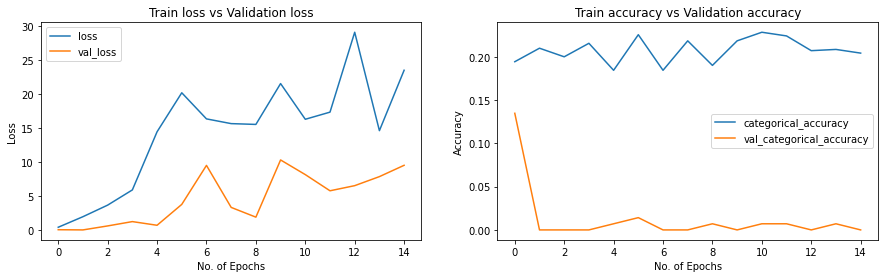

Max. Training Accuracy 0.22836878895759583
Max. Validaiton Accuracy 0.13475176692008972


In [37]:
plotModelHistory(model2_history)

## 😅 This is bad !! 

Where am i failing?

# Model 3 - Use Relu instead of elu

In [38]:
def getEvenTensor():
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]     
    return [img_idx, 100, 100, 3]

In [39]:
model = Sequential()


model.add(Conv3D(16,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu',input_shape=(15, 100, 100, 3)))
model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.25))


model.add(Conv3D(64,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(5, activation='softmax'))

In [41]:
optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 100, 100, 32)  13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 5, 33, 33, 32)    0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 5, 33, 33, 32)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 5, 33, 33, 64)     55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 1, 11, 11, 64)    0         
 g3D)                                                 

In [42]:
num_epochs = 15
batch_size = 47

image_tensor = getEvenTensor()

train_generator = generatorWithTensor(train_path, train_doc, batch_size,image_tensor)
val_generator = generatorWithTensor(val_path, val_doc, batch_size,image_tensor)



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model3_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



<ipython-input-42-f2a34ac0a990>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 47
Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.3743 - categorical_accuracy: 0.1433 Source path =  Project_data/val ; batch size = 47

Epoch 1: saving model to model_init_2022-08-2307_49_20.252606/model-00001-0.37431-0.14326-0.61425-0.01418.h5
15/15 [==============================] - 720s 48s/step - loss: 0.3743 - categorical_accuracy: 0.1433 - val_loss: 0.6143 - val_categorical_accuracy: 0.0142 - lr: 0.0010
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 20.9384 - categorical_accuracy: 0.1830 
Epoch 2: saving model to model_init_2022-08-2307_49_20.252606/model-00002-20.93840-0.18298-9.91514-0.00000.h5
15/15 [==============================] - 719s 48s/step - loss: 20.9384 - categorical_accuracy: 0.1830 - val_loss: 9.9151 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 117.4933 - categorical_accuracy: 0.1901 
Epoch 3: savin

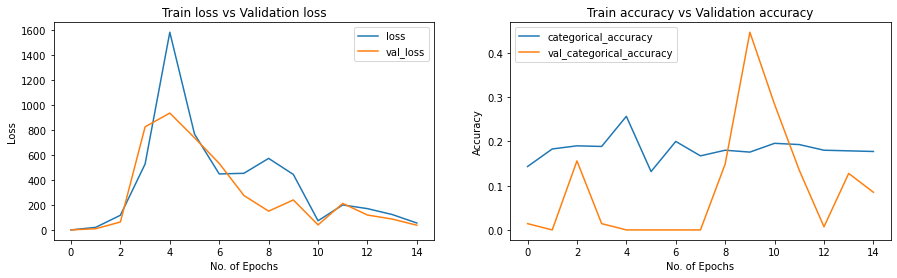

Max. Training Accuracy 0.2567375898361206
Max. Validaiton Accuracy 0.44680851697921753


In [43]:
plotModelHistory(model3_history)

#### Not much change in Training Accuracy.

# Model 4 - 

    - Increasing batch size
    - Increasing EPOCH
    - removed dropouts

In [45]:
model = Sequential()


model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu',input_shape=(15, 100, 100, 3)))
model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))

model.add(Conv3D(64,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(Conv3D(64,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 15, 100, 100, 32)  2624      
                                                                 
 conv3d_23 (Conv3D)          (None, 15, 100, 100, 32)  27680     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 5, 33, 33, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_24 (Conv3D)          (None, 5, 33, 33, 64)     55360     
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 33, 33, 64)     110656    
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 1, 11, 11, 64)    0         
 g3D)                                                 

In [46]:
num_epochs = 20
batch_size = 55

image_tensor = getEvenTensor()

train_generator = generatorWithTensor(train_path, train_doc, batch_size,image_tensor)
val_generator = generatorWithTensor(val_path, val_doc, batch_size,image_tensor)



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model4_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



<ipython-input-46-4f384f97fcb8>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 55
Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 3.5509 - categorical_accuracy: 0.2126  Source path =  Project_data/val ; batch size = 55

Epoch 1: saving model to model_init_2022-08-2307_49_20.252606/model-00001-3.55086-0.21259-18.43214-0.00000.h5
13/13 [==============================] - 1167s 91s/step - loss: 3.5509 - categorical_accuracy: 0.2126 - val_loss: 18.4321 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 236.8106 - categorical_accuracy: 0.2056  
Epoch 2: saving model to model_init_2022-08-2307_49_20.252606/model-00002-236.81056-0.20559-286.44772-0.00909.h5
13/13 [==============================] - 1030s 79s/step - loss: 236.8106 - categorical_accuracy: 0.2056 - val_loss: 286.4477 - val_categorical_accuracy: 0.0091 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 6696.2373 - categorical_accuracy: 0.1622  

Epoch 20/20
13/13 [==============================] - ETA: 0s - loss: 410814.4688 - categorical_accuracy: 0.1832  
Epoch 20: saving model to model_init_2022-08-2307_49_20.252606/model-00020-410814.46875-0.18322-416451.50000-0.47273.h5
13/13 [==============================] - 971s 75s/step - loss: 410814.4688 - categorical_accuracy: 0.1832 - val_loss: 416451.5000 - val_categorical_accuracy: 0.4727 - lr: 8.0000e-06


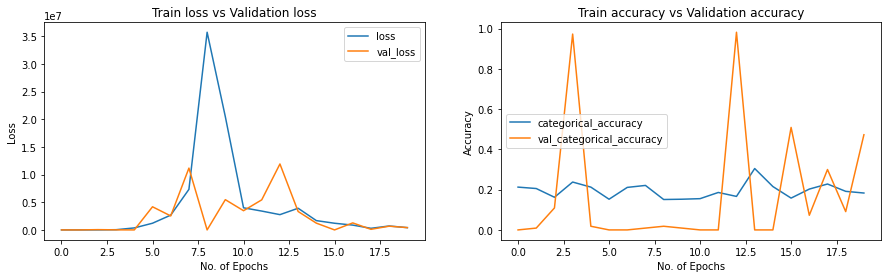

Max. Training Accuracy 0.3048951029777527
Max. Validaiton Accuracy 0.9818181991577148


In [47]:
plotModelHistory(model4_history)

#### Accuracy is slightly improved but there is huge difference to validation accuracy

    - Accuracy is improved after removing dropouts but training accuracy has not increased a lot.
    - validation accuracy is sky rocketing comparatively. this could be because of data.
    - training it for more time might increase the training accuracy

# Model 5
        - Include all frames and image resized to 120x120
        - Increased epoch and batch size


In [81]:
def getAllTensor():
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]     
    return [img_idx, 120, 120, 3]

In [82]:
model = Sequential()


model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu',input_shape=(30, 120, 120, 3)))
model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(BatchNormalization())



model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(Conv3D(32,strides=(1, 1, 1),padding='same', kernel_size=(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(BatchNormalization())



model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_54 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 conv3d_55 (Conv3D)          (None, 30, 120, 120, 32)  27680     
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 10, 40, 40, 32)   128       
 chNormalization)                                                
                                                                 
 conv3d_56 (Conv3D)          (None, 10, 40, 40, 32)    27680     
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 40, 40, 32)  

In [83]:
image_tensor = getAllTensor()

# check complete batch shape
sample_generator = generatorWithTensor(train_path, train_doc, 20,image_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generatorWithTensor(val_path, val_doc, 20,image_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)


Source path =  Project_data/train ; batch size = 20
(20, 30, 120, 120, 3)
Source path =  Project_data/val ; batch size = 20
(20, 30, 120, 120, 3)


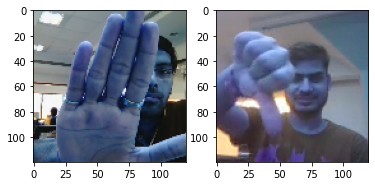

In [84]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[2,10,:,:,:])
plt.show()

In [85]:
num_epochs = 33
batch_size = 65

image_tensor = getAllTensor()

train_generator = generatorWithTensor(train_path, train_doc, batch_size,image_tensor)
val_generator = generatorWithTensor(val_path, val_doc, batch_size,image_tensor)



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



model4_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



<ipython-input-85-56149a3b2210>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 65
Epoch 1/33
11/11 [==============================] - ETA: 0s - loss: 0.0465 - categorical_accuracy: 0.2042  Source path =  Project_data/val ; batch size = 65

Epoch 1: saving model to model_init_2022-08-2307_49_20.252606/model-00001-0.04655-0.20420-0.02519-0.00000.h5
11/11 [==============================] - 2970s 270s/step - loss: 0.0465 - categorical_accuracy: 0.2042 - val_loss: 0.0252 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/33
11/11 [==============================] - ETA: 0s - loss: 0.0331 - categorical_accuracy: 0.2322  
Epoch 2: saving model to model_init_2022-08-2307_49_20.252606/model-00002-0.03307-0.23217-0.01636-0.00769.h5
11/11 [==============================] - 2967s 270s/step - loss: 0.0331 - categorical_accuracy: 0.2322 - val_loss: 0.0164 - val_categorical_accuracy: 0.0077 - lr: 0.0010
Epoch 3/33
11/11 [==============================] - ETA: 0s - loss: 0.0305 - categorical_accuracy: 0.1329  
Epoch 3: sav

KeyboardInterrupt: 

### Had to stop as it was taking lot more time on personal macbook.

# MODEL 6 - Conv2D+LSTM
            
                - using 15 frames, 10 epochs and 55 batch size
                - 100x100 cropping of image
                


In [92]:
from keras.layers import Conv2D, MaxPooling2D,LSTM


In [93]:
def make2dFilter(x):
    return tuple([x]*2)

In [94]:
image_tensor = getEvenTensor()
num_epochs = 10
batch_size = 55

inputShape = (len(image_tensor[0]), image_tensor[1], image_tensor[2], image_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(64),
    Dropout(0.25),

    Dense(64, activation='relu'),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 50, 50, 32)   2080      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 50, 50, 32)  

In [95]:
train_generator = generatorWithTensor(train_path, train_doc, batch_size,image_tensor)
val_generator = generatorWithTensor(val_path, val_doc, batch_size,image_tensor)



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-95-04ec677ec117>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 55
Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.0307 - categorical_accuracy: 0.4615 Source path =  Project_data/val ; batch size = 55

Epoch 1: saving model to model_init_2022-08-2307_49_20.252606/model-00001-0.03072-0.46154-0.02861-0.00000.h5
13/13 [==============================] - 162s 13s/step - loss: 0.0307 - categorical_accuracy: 0.4615 - val_loss: 0.0286 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.0448 - categorical_accuracy: 0.3622 
Epoch 2: saving model to model_init_2022-08-2307_49_20.252606/model-00002-0.04480-0.36224-0.03089-0.00909.h5
13/13 [==============================] - 155s 13s/step - loss: 0.0448 - categorical_accuracy: 0.3622 - val_loss: 0.0309 - val_categorical_accuracy: 0.0091 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.0449 - categorical_accuracy: 0.4014  
Epoch 3: saving mo

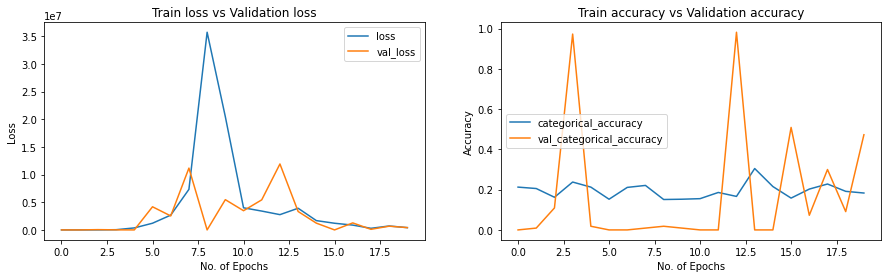

Max. Training Accuracy 0.3048951029777527
Max. Validaiton Accuracy 0.9818181991577148


In [96]:
plotModelHistory(model4_history)

# Similar results of Model 6  & Model 4

### - Model 6 - Conv2d & LSTM 
                -- TimeDistributed Conv2d, BatchNormalization, Dropout
                -- num_epochs = 10, batch_size = 55, Img size 15 X 100 x 100
                -- Max. Training Accuracy 0.3048951029777527
                -- Max. Validaiton Accuracy 0.9818181991577148

### Model 4 - 
                -- Conv3D
                -- num_epochs = 20, batch_size = 55, Img size 15 X 100 x 100
                -- Max. Training Accuracy 0.3048951029777527
                -- Max. Validaiton Accuracy 0.9818181991577148
                
                

